In [384]:
import numpy as np
import pandas as pd
import os 
rutaBase = os.getcwd().replace('\\', '/') + '/'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from calendar import monthrange, isleap

## SAIH-CHC

In [2]:
rutaCHC = 'F:/OneDrive - Universidad de Cantabria/Series/CHC/SAI/tratadas/5min/'
rutaOut = 'F:/OneDrive - Universidad de Cantabria/Clases/Grado/G1448 - Hydrology/Exercises/1-Precipitation/data/'

In [3]:
#stns = ['A618', 'A605', 'A621', 'A623', 'Q101', 'A614', 'A353', 'A073', 'N033',
#        'A603', 'A074', 'A619', 'A600']
stnsSAIH = ['P668']

In [23]:
dict_pcp = {}
start, end = pd.datetime(2100, 12, 31, 23, 55), pd.datetime(1900, 1, 1, 0, 0)
for stn in stnsSAIH:
    aux = pd.read_csv(rutaCHC + stn + '.csv', encoding='latin1', parse_dates=True, index_col=0)
    dict_pcp[stn] = aux.precipitacion_mm
    start = min(start, aux.index.min())
    end = max(end, aux.index.max())
    
start = np.min([dict_pcp[stn].index.min() for stn in dict_pcp])
end = np.max([dict_pcp[stn].index.max() for stn in dict_pcp])
print(start, end)

2011-05-02 00:00:00 2019-05-31 23:55:00


In [24]:
pcp_5min_SAIH = pd.DataFrame(index=pd.date_range(start, end, freq='5min'), columns=stnsSAIH)
pcp_5min_SAIH.index.name = 'datetime'
for stn in stnsSAIH:
    st, en = dict_pcp[stn].index[0], dict_pcp[stn].index[-1]
    pcp_5min_SAIH.loc[st:en, stn] = dict_pcp[stn]

In [25]:
pcp_h_SAIH = pcp_5min_SAIH.resample('h').sum()

In [26]:
start_SAIH = pd.datetime(2012, 1, 1, 0, 0, 0)
end_SAIH = pd.datetime(2018, 12, 31, 23, 55, 0)
pcp_h_SAIH = pcp_h_SAIH.loc[start_SAIH:end_SAIH,:]

In [9]:
pcp_h_SAIH.to_csv('../data/hourly_precipitation_Oviedo_SAIH.csv', float_format='%.1f')

In [10]:
pcp_h_SAIH = pd.read_csv('../data/hourly_precipitation_Oviedo_SAIH.csv', parse_dates=True, index_col=0)

## Datos AEMET
### Horario

In [11]:
rutaAEMET = 'G:/CLIMA/02_HYDRO-CLIMATE/AEMET/precipitacion/horario/'

In [12]:
stnsAEMET = ['1249I']#, '1235', '1247','1250', '1245E']

In [13]:
rawAEMET = pd.read_csv(rutaAEMET + 'output/Dataframe_hourly.csv', parse_dates=True, index_col=0)

In [14]:
pcp_h_AEMET = pd.DataFrame(data=rawAEMET[stnsAEMET], columns=stnsAEMET)
pcp_h_AEMET.index.name = 'datetime'

In [15]:
# recortar datos
startAEMET = pd.datetime(2005, 1, 1, 0, 0, 0)
endAEMET = pd.datetime(2014, 12, 31, 23, 55 ,0)
pcp_h_AEMET = pcp_h_AEMET.loc[startAEMET:endAEMET,:]
pcp_h_AEMET /= 10

In [16]:
# exportar
pcp_h_AEMET.to_csv('../data/hourly_precipitation_Oviedo_AEMET.csv', float_format='%.1f')

In [17]:
# importar
pcp_h_AEMET = pd.read_csv('../data/hourly_precipitation_Oviedo_AEMET.csv', parse_dates=True, index_col=0)

### Diario

In [18]:
def AEMET_Pdiaria(estacion, provincia):
    """
    Parámetros:
    -----------
    estacion:  string. Código de la estación
    provinvia: string. Provincia a la que pertenece la estación. Define el archivo csv donde acceder a los datos, por lo que debe replicar 
                       el nombre del archivo, es decir, primera letra en mayúsucula y sin ninguna tilde.
                       
    Salidas:
    --------
    serie:     pd.Series. Serie diaria de precipitación en mm
    atributos: pd.Series. Atributos de la estación: coordenadas, altitud...
    """

    # cargar datos burtos de la provincia
    ruta = 'G:/CLIMA/02_HYDRO-CLIMATE/AEMET/precipitacion/diario/'
    raw = pd.read_csv(ruta + provincia + '.csv', sep=';', encoding='latin1')
    # extraer datos de la estación
    data = raw.loc[raw.INDICATIVO == estacion,:]
    
    # ATRIBUTOS
    # .........
    atributos = data[['NOMBRE', 'ALTITUD', 'NOM_PROV', 'LONGITUD', 'LATITUD', 'DATUM']].iloc[0]
    
    # SERIE DIARIA
    # ...........
    # fechas de la serie
    start = pd.datetime(data.AÑO.iloc[0], data.MES.iloc[0], 1).date()
    year, month = data.AÑO.iloc[-1], data.MES.iloc[-1]
    end = pd.datetime(year, month, monthrange(year, month)[1]).date()
    fechas = pd.date_range(start, end)
    # ordenar datos en una serie
    serie = pd.Series(index=fechas)
    cols = ['P' + str(i) for i in np.arange(1, 32)]
    for idx in data.index:
        year, month = data.loc[idx, ['AÑO', 'MES']]
        days = monthrange(year, month)[1]
        d = pd.date_range(pd.datetime(year, month, 1), pd.datetime(year, month, days))
        serie[d] = data.loc[idx, cols[:days]]
    # corregir serie
    serie[serie == -3] = 0
    serie[serie == -4] = np.nan
    serie /= 10
        
    return serie, atributos

In [122]:
stnsAEMET = ['1249I', '1235']#, '1247','1250', '1245E']
stnsAEMET = ['1206', '1206A', '1208', '1208E', '1210',
             '1212E', '1216', '1229U', '1235', '1239I',
             '1245E', '1247', '1247I', '1248', '1249I',
             '1250', '1251', '1252', '1269', '1271B',
             '1272', '1273', '1274', '1276E', '1281',
             '1288']#, '2645', '2653', '2654', '2685A',
             #'2686', '2688', '2689', '2692', '2693',
             #'2695', '2697', '2698', '2698A', '2699A']
provincia = 'Asturias'

#### Serie diaria observada

In [210]:
# importar datos en un diccionario
pcp_d_AEMET = {stn: {} for stn in stnsAEMET}
for stn in stnsAEMET:
    print('{0:>5}'.format(stn), end='\r')
    pcp_d_AEMET[stn]['pcp'], pcp_d_AEMET[stn]['atrs'] = AEMET_Pdiaria(stn, 'Asturias')

start = np.min([pcp_d_AEMET[stn]['pcp'].index.min() for stn in pcp_d_AEMET])
end = np.max([pcp_d_AEMET[stn]['pcp'].index.max() for stn in pcp_d_AEMET])
print(start, end)

1941-06-01 00:00:00 2018-01-31 00:00:00


In [212]:
# reorganizar datos en un 'data frame'
pcp_d = pd.DataFrame(index=pd.date_range(start, end), columns=stnsAEMET)
for stn in stnsAEMET:
    serie = pcp_d_AEMET[stn]['pcp']
    st, en = serie.index[0], serie.index[-1]
    pcp_d.loc[st:en, stn] = serie
# recortar desde 2005 y sólo la estación de Oviedo
#start, end = pcp_d.first_valid_index(), pcp_d.last_valid_index()
start, end = pd.datetime(2005, 1, 1), pcp_d.last_valid_index()
pcp_d_AEMET = pcp_d.loc[start:end,:]
pcp_d_AEMET.dropna(axis=1, how='all', inplace=True)

C:\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [222]:
pcp_d_AVG = pcp_d_AEMET.mean(axis=1)

#### Serie anual observada

In [412]:
# precipitación anual media
pcp_y_AEMET = pcp_d_AEMET.resample('y').sum() / pcp_d_AEMET.resample('y').count()
# eliminar años con pocos datos
pcp_y_AEMET[pcp_d_AEMET.resample('y').count() < 300] = np.nan
# eliminar años sin datos
pcp_y_AEMET.dropna(axis=0, how='all', inplace=True)
# eliminar estaciones con menos del 75% de los años
pcp_y_AEMET = pcp_y_AEMET.loc[:, pcp_y_AEMET.count(axis=0) / pcp_y_AEMET.shape[0] > .75]
# convertir el índice en el año
#pcp_y_AEMET.index = [idx.year for idx in pcp_y_AEMET.index]
# convertir en precipitación anual acumulada
for idx in pcp_y_AEMET.index:
    if isleap(idx.year):
        pcp_y_AEMET.loc[idx,:] *= 366
    else:
        pcp_y_AEMET.loc[idx,:] *= 365
# media entre estaciones
pcp_y_AEMET['AVG'] = np.nanmean(pcp_y_AEMET, axis=1)

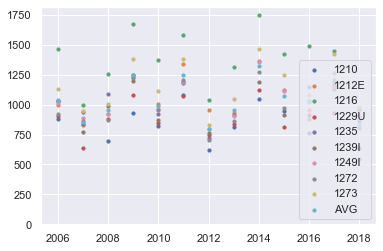

In [413]:
for stn in pcp_y_AEMET.columns:
    plt.scatter(pcp_y_AEMET.index, pcp_y_AEMET[stn], s=10, label=stn)
plt.ylim(0)
plt.legend();

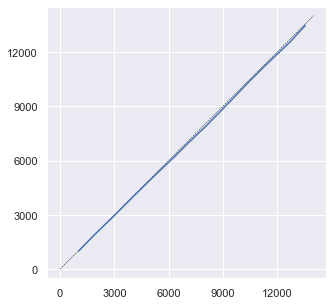

In [414]:
doubleMass(pcp_y_AEMET.AVG, pcp_y_AEMET['1249I'])#, redondeo=10, marcas=8)

## Double mass curve

plt.figure(figsize=(15, 4))
plt.plot(pcp_d_AEMET, linewidth=.5, alpha=.75, label='AEMET_d')
plt.plot(pcp_h_AEMET, linewidth=.5, alpha=.75, label='AEMET_h')
plt.plot(pcp_h_SAIH, linewidth=.5, alpha=.75, label='SAIH_h')
plt.legend();

plt.figure(figsize=(15, 4))
plt.plot(pcp_d_AEMET, linewidth=.5, alpha=.75, label='AEMET_d')
plt.plot(pcp_h_AEMET.resample('d').sum(), linewidth=.5, alpha=.75, label='AEMET_h')
#plt.plot(pcp_h_SAIH.resample('d').sum(), linewidth=.5, alpha=.75, label='SAIH_h')
plt.xlim('2006', '2007')
plt.legend();

serie_d = pd.concat((pcp_d_AEMET, pcp_h_AEMET.resample('d').sum(), pcp_h_SAIH.resample('d').sum()), axis=1)
serie_d.tail(2)

serie_d.corr()

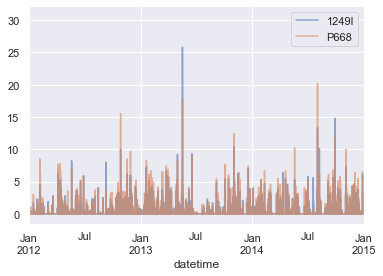

In [473]:
pcp_h = pd.concat((pcp_h_AEMET, pcp_h_SAIH), axis=1)
pcp_hm = pcp_h.min(axis=1)
pcp_hM = pcp_h.max(axis=1)

pcp_h.plot(alpha=.6)
plt.xlim('2012-1-1', '2015-1-1');

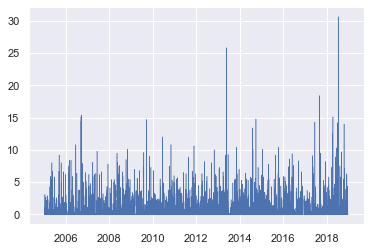

In [479]:
# unir serie horaria AEMET y serie horaria SAIH
pcp_hA = pd.Series(index=pd.date_range(pcp_h_AEMET.index[0], pcp_h_SAIH.index[-1], freq='h'))
pcp_hA[pcp_h_AEMET.index[0]:pcp_h_AEMET.index[-1]] = pcp_h_AEMET['1249I']
pcp_hA['2015-1-1':] = pcp_h_SAIH.loc['2015-1-1':, 'P668']
plt.plot(pcp_hA, lw=.5);

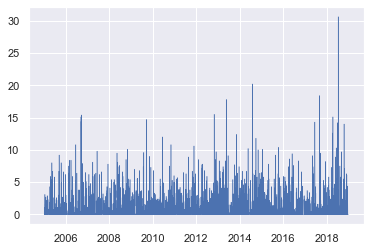

In [481]:
# unir serie horaria AEMET y serie horaria SAIH
pcp_hS = pd.Series(index=pd.date_range(pcp_h_AEMET.index[0], pcp_h_SAIH.index[-1], freq='h'))
pcp_hS[:'2011-12-31'] = pcp_h_AEMET.loc[:'2011-12-31', '1249I']
pcp_hS['2012-1-1':] = pcp_h_SAIH.loc['2012-1-1':, 'P668']
plt.plot(pcp_hS, lw=.5);

In [ ]:
#pcp_h = pd.concat((pcp_h_AEMET['1249I'], pcp_h_SAIH['P668']), axis=0, join='outer', )
#plt.plot(pcp_h, lw=.5);

In [456]:
def doubleMass(serie1, serie2, redondeo=1000, marcas=3000, years=None, ax=None, **kwargs):
    """
    """
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    seriecum1, seriecum2 = serie1.cumsum(), serie2.cumsum()
    xymax = np.ceil(max(seriecum1.max(), seriecum2.max()) / redondeo) * redondeo
    ax.plot((0, xymax), (0, xymax), ls='--', lw=.5, c='k')
    if years is not None:
        for year in years:
            i_year = np.where(serie1.index.year == year)[0][0]
            ax.vlines(seriecum1.iloc[i_year], 0, seriecum2.iloc[i_year], ls='--', lw=.5, color='k')
            ax.hlines(seriecum2.iloc[i_year], 0, seriecum1.iloc[i_year], ls='--', lw=.5, color='k')
            ax.text(0, seriecum2.iloc[i_year] + xymax/40, str(year), c='k')
    ax.plot((0, seriecum1.max()), (0, seriecum2.max()), ls='--', lw=.5, c='steelblue')
    ax.plot(seriecum1, seriecum2)
    ax.set(xlim=(0,xymax), ylim=(0,xymax))
    ticks = np.arange(0, xymax + 1, marcas)
    if 'xlabel' in kwargs:
        ax.set_xlabel(kwargs['xlabel'])
    if 'ylabel' in kwargs:
        ax.set_ylabel(kwargs['ylabel'])
    if 'title' in kwargs:
        ax.set_title(kwargs['title'])
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.axis('equal');

#### Curva de doble masa diaria

In [484]:
# remuestrer la serie de unión a diario
pcp_d = pcp_hA.resample('d').sum() # .mean() * 24
# recortar a la longitud de la serie diaria observada
pcp_d = pcp_d[pcp_d_AEMET.index]

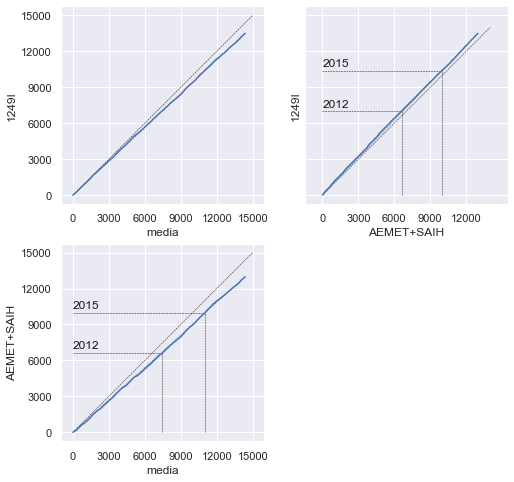

In [485]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True)

doubleMass(pcp_d_AVG, pcp_d_AEMET['1249I'], ax=axes[0,0], xlabel='media', ylabel='1249I')
doubleMass(pcp_d, pcp_d_AEMET['1249I'], years=[2012, 2015], ax=axes[0,1], xlabel='AEMET+SAIH', ylabel='1249I')
doubleMass(pcp_d_AVG, pcp_d, ax=axes[1,0], years=[2012, 2015], xlabel='media', ylabel='AEMET+SAIH')
axes[1,1].axis('off');

In [492]:
pcp_hA_df = pd.DataFrame(data=pcp_hA, columns=['P(mm)'])
pcp_hA_df.index.name = 'datetime'

pcp_hA_df.to_csv('../data/hourly_precipitation_Oviedo_AEMET+SAIH.csv', float_format='%.1f')

La gráfica superior izquierda compara los datos diarios de la estación 1249I con sus correspondientes en el resto de estaciones cercanas. A simple vista se comprueba que la estación 1249I tiene una precipitación ligeramente superior a la media de las estaciones cercanas (pendiente menor que 1), pero no parece haber saltos en dicha tendencia, con lo que los datos serían válidos.

La gráfica superior derecha compara los datos diarios de la estación 1249I con la agregación diaria de la unión de la serie horaria de las estaciones 1249I y P668. La línea de puntos azul representa el momento de unión de las series (1 de enero de 2015). Los datos horarios y diarios de la estación 1249I no concuerdan, puesto que no siguen perfectamente la línea de pendiente 1; en cierto punto la curva de doble masa supera dicha línea (más precipitación horaria que diaria), para más adelante recuperarla (más precipitación diaria que horaria). La unión de las series es adecuada, en cuanto a que la curva de doble masa sigue perfectamente la recta de pendiente 1.

La gráfica inferior compara la media de los datos diarios de la AEMET frente a la agregación diaria de la unión de la serie horaria de las estaciones 1249I y P668. La línea de puntos azul representa el momento de unión de las series (1 de enero de 2015). De nuevo se observa cierta fluctuación en la curva de doble masa entre 2010 y 2015; primeramente los datos horarios superan a la media, para luego retomar la senda original. Al igual que ocurría en la primera gráfica, se observa que la precipitación en Oviedo es ligeramente superior a la de su entorno.

Se considera que los datos diarios de la AEMET son más fiables que los horarios y, por tanto, estos últimos deberían ser corregidos frente a los primeros.

#### Curva de doble masa anual

In [493]:
# remuestrer la serie de unión a anual
pcp_y = pcp_hA.resample('y').sum() # .mean() * 24
#pcp_y.index = [idx.year for idx in pcp_y.index]
# recortar a la longitud de la serie diaria observada
pcp_y = pcp_y[pcp_y_AEMET.index]

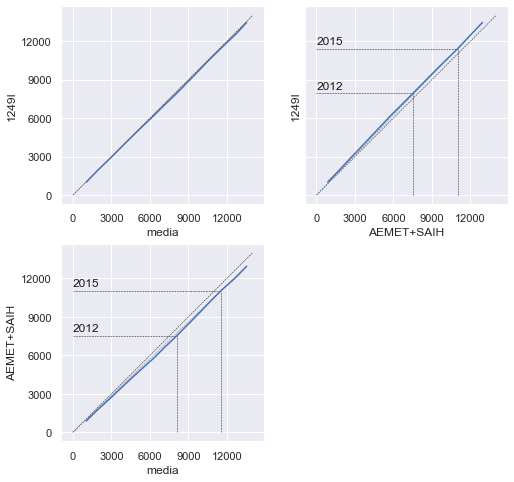

In [495]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True)

doubleMass(pcp_y_AEMET.AVG, pcp_y_AEMET['1249I'], ax=axes[0,0], xlabel='media', ylabel='1249I')
doubleMass(pcp_y, pcp_y_AEMET['1249I'], years=[2012, 2015], ax=axes[0,1], xlabel='AEMET+SAIH', ylabel='1249I')
doubleMass(pcp_y_AEMET.AVG, pcp_y, years=[2012, 2015], ax=axes[1,0], xlabel='media', ylabel='AEMET+SAIH')
axes[1,1].axis('off');

El análisis es básicamente el mismo que el hecho anteriormente para las series diarias.

In [ ]:

pcp_d = pd.concat((pcp_d_AEMET, pcp_d_aux), axis=1)
pcp_d.columns = ['AEMET', 'Agg']
pcp_d = pcp_d.loc[:pcp_d_AEMET.index[-1],:]
pcp_d.head()

In [ ]:
pcp_d.plot()

In [ ]:
pcp_d.shape

In [ ]:
a, b = pcp_d.AEMET.cumsum(), pcp_d.Agg.cumsum()

In [ ]:
plt.plot(a, label='AEMET')
plt.plot(b, label='agregado');

In [ ]:
plt.scatter(pcp_d.AEMET.cumsum(), pcp_d.Agg.cumsum(), s=5);
#plt.xticks(pcp_d.index);

### Annual series
#### AEMET

In [ ]:
pcp_d_cum = pcp_d_AEMET.cumsum()
pcp_d_cum['AVG'] = pcp_d_cum.mean(axis=1)

In [ ]:
plt.scatter(pcp_d_cum['1235'], pcp_d_cum['1249I'], s=5)

In [ ]:
plt.scatter(pcp_d_cum.AVG, pcp_d_cum['1249I'], s=5)

In [ ]:
pcp_h_SAIH.index[0], pcp_h_SAIH.index[-1]

In [ ]:
plt.plot(pcp_d_AEMET.resample('y').sum())

In [ ]:
# annaul series
pcp_an_AEMET = pcp_h_AEMET.resample('y').sum()

In [ ]:
plt.plot(pcp_d_AEMET.resample('y').sum())
plt.plot(pcp_h_AEMET.resample('y').sum())
plt.plot(pcp_h_SAIH.resample('y').sum());

In [ ]:
pcp_h_SAIH.resample('y').count()

#### SAIH

In [ ]:
pcp_h_SAIH.first_valid_index(), pcp_h_SAIH.last_valid_index()

In [ ]:
pcp_an_SAIH = pcp_h_SAIH.resample('y').sum()

In [ ]:
pcp_an_AEMET.cumsum()

In [ ]:
pcp_an = pd.concat((pcp_an_AEMET, pcp_an_SAIH), axis=1)
pcp_an['AVG'] = pcp_an.mean(axis=1)
pcp_an.index = pcp_an.index.year
pcp_an.head()

In [ ]:
pcp_an.P668.cumsum()

In [ ]:
plt.scatter(pcp_an.P668.cumsum(), pcp_an.AVG.cumsum())

In [ ]:
plt.scatter(pcp_an.index, pcp_an['1249I'])
plt.scatter(pcp_an.index, pcp_an['P668']);

In [ ]:
plt.scatter(pcp_an_AEMET.index, pcp_an_AEMET.cumsum());
plt.scatter(pcp_an_SAIH.index, pcp_an_SAIH.cumsum())

In [ ]:
st, en = pcp_h_SAIH.index[0], pcp_h_AEMET.index[-1]

In [ ]:
pcp_h = pd.concat((pcp_h_AEMET, pcp_h_SAIH), axis=1)
pcp_h = pcp_h.loc[st:en,:]
pcp_h['AVG'] = pcp_h.mean(axis=1)
pcp_h.head()

In [ ]:
pcp_cumsum = pcp_h.cumsum()

In [ ]:
plt.scatter(pcp_cumsum.AVG, pcp_cumsum['1249I'])